In [54]:
# Refer to https://www.tensorflow.org/tutorials/images/classification#download_and_explore_the_dataset

import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz -P .
!tar -xvf flower_photos.tgz

In [58]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [59]:
print(data_dir)

/root/.keras/datasets/flower_photos


In [60]:
!ls -l /root/.keras/datasets/flower_photos

total 616
drwx------ 2 270850 5000  36864 Feb 10  2016 daisy
drwx------ 2 270850 5000  57344 Feb 10  2016 dandelion
-rw-r----- 1 270850 5000 418049 Feb  9  2016 LICENSE.txt
drwx------ 2 270850 5000  36864 Feb 10  2016 roses
drwx------ 2 270850 5000  36864 Feb 10  2016 sunflowers
drwx------ 2 270850 5000  36864 Feb 10  2016 tulips


In [4]:
batch_size = 32
img_height = 180
img_width = 180

# # /train
#     -- train
#     -- val
# # /test
#     -- test

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# test_ds = tf.keras.utils.image_dataset_from_directory(
#   '/root/.keras/datasets/flower_photos/',
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [6]:
type(train_ds)

tensorflow.python.data.ops.batch_op._BatchDataset

In [ ]:
# https://www.tensorflow.org/guide/gpu#overview

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)

Num GPUs Available:  1


In [ ]:
!nvidia-smi

Sun Jul 23 04:53:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W /  70W |    389MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# We need to scale - lets add the scaling layer in Network itself
num_classes = len(class_names)
with strategy.scope():
  # Lets add Data Aug Layers (!!!!)
  data_augmentation = keras.Sequential(
    [
      layers.RandomFlip("horizontal",
                        input_shape=(img_height,
                                    img_width,
                                    3)),
      layers.RandomRotation(0.1),
      layers.RandomZoom(0.1),
    ]
  )
  model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
# with strategy.scope():
  epochs=15
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

Epoch 1/15
92/92 [==============================] - 20s 77ms/step - loss: 1.2968 - accuracy: 0.4438 - val_loss: 1.0168 - val_accuracy: 0.6063
Epoch 2/15
92/92 [==============================] - 7s 78ms/step - loss: 1.0077 - accuracy: 0.6124 - val_loss: 1.0061 - val_accuracy: 0.6294
Epoch 3/15
92/92 [==============================] - 6s 61ms/step - loss: 0.9084 - accuracy: 0.6540 - val_loss: 0.9821 - val_accuracy: 0.6035
Epoch 4/15
92/92 [==============================] - 7s 75ms/step - loss: 0.8669 - accuracy: 0.6645 - val_loss: 0.8229 - val_accuracy: 0.6935
Epoch 5/15
92/92 [==============================] - 6s 61ms/step - loss: 0.7830 - accuracy: 0.7061 - val_loss: 0.8771 - val_accuracy: 0.6744
Epoch 6/15
92/92 [==============================] - 7s 76ms/step - loss: 0.7657 - accuracy: 0.7142 - val_loss: 0.8627 - val_accuracy: 0.6689
Epoch 7/15
92/92 [==============================] - 6s 64ms/step - loss: 0.7248 - accuracy: 0.7234 - val_loss: 0.9362 - val_accuracy: 0.6417
Epoch 8/15
9

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
model.save('cnn-flowers-gpu-15epoc.h5')

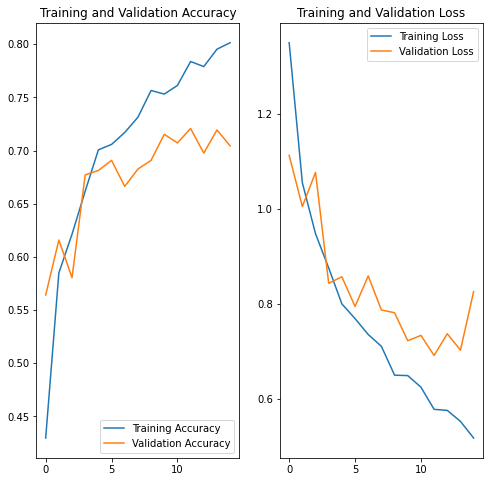

In [ ]:
# Now how does it looks like ?

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Using ImageDataGenerator Class
Example Code to use ImageDataGenerator class.

In [61]:
data_dir = '/root/.keras/datasets/flower_photos'

In [62]:
! ls /root/.keras/datasets/flower_photos

daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


In [65]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rescale=1.0/255.)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rescale=1.0/255.)

batch_size = 32
img_height = 180
img_width = 180
train_generator = train_gen.flow_from_directory(
  data_dir,
  seed=123,
  target_size=(img_height, img_width),
  batch_size=batch_size)
# val_ds = train_gen.flow_from_directory(
#   data_dir,
#   seed=123,
#   target_size=(img_height, img_width),
#   batch_size=batch_size)

Found 3670 images belonging to 5 classes.


In [64]:
# categorical and the classes are from 0 to 4
# also this is y_train
train_generator.classes

array([0, 0, 0, ..., 4, 4, 4], dtype=int32)

In [67]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(5, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# with strategy.scope():
epochs=1
history = model.fit(
  train_generator,
  epochs=epochs
)

115/115 [==============================] - 94s 799ms/step - loss: 1.6049 - accuracy: 0.2313


In [ ]:
zip_file_path = '/content/drive/MyDrive/Dataset_Detection_of_Lung_Infection.zip'
extract_path = '/content/sample_data/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

trainLungData = pathlib.Path('/content/sample_data/data/train/')
testLungData = pathlib.Path('/content/sample_data/data/test/')
train_ds = tf.keras.utils.image_dataset_from_directory(
  trainLungData,
  validation_split=0.2,
  subset="training",
  image_size = (48,48)
  )
val_ds = tf.keras.utils.image_dataset_from_directory(
  trainLungData,
  validation_split=0.2,
  subset="validation",
  image_size = (48,48)
  )
test_ds = tf.keras.utils.image_dataset_from_directory(
  trainLungData,
  image_size = (48,48)
  )